# Workflow Model 1

## Import dataset

- For this model, we decide to import the dataset via KaggleHub.
- The model will be saved locally.
- We then print and save the path in a dotenv file for data protection.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals10


In [2]:
DATASET_URI="/kaggle/input/animals10/raw-img"

In [ ]:
# from dotenv import dotenv_values

# # Retrieve dotenv config
# config = dotenv_values(".env")

# # Retrieve DATASET_URI
# DATASET_URI=config["DATASET_URI"]

## Pre-processing

### Imports

In [3]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras

### Data conversion

In [4]:
# Define the parameters.

random.seed(10)
batch_size = 32 # TODO : increase batch size
img_height = 224 # TODO : add comment on what it does
img_width = 224 # TODO : add comment on what it does
seed = random.randint(1, 200)

# We then import the dataset from directory and store the data in train and test.
# We follow a rule of 80% for training and 20% for testing.

train_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.2, # TODO : 0.1
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)

test_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

# We print the class names for double check.

print(f"Training classes => {train_ds.class_names}")
print(f"Testing classes => {test_ds.class_names}")


Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
Training classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Testing classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


### Data visualisation

#### Shape

The results below tell us that :

- The image_batch is a tensor of the shape (32, 180, 180, 3).
- This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB).
- The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [5]:
# Print the shapes of the training and the testing dataset
for image_batch, labels_batch in train_ds:
    print(f"Shape of the training set images => {image_batch.shape}")
    print(f"Shape of the training set labels => {labels_batch.shape}")
    break

for image_batch, labels_batch in test_ds:
    print(f"Shape of the testing set images => {image_batch.shape}")
    print(f"Shape of the testing set labels => {labels_batch.shape}")
    break

Shape of the training set images => (32, 224, 224, 3)
Shape of the training set labels => (32,)
Shape of the testing set images => (32, 224, 224, 3)
Shape of the testing set labels => (32,)


#### Pre-visualization

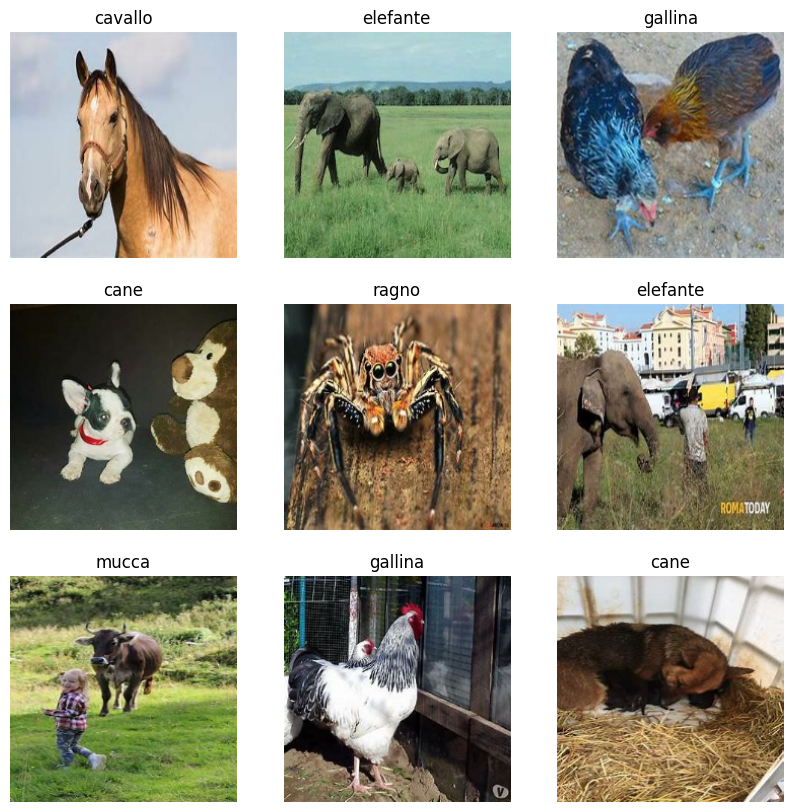

In [6]:
# Print a summary of the image classes with an image of each class.
# We will extract 1 image of the training set.

plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
  for i in range(len(class_names) - 1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model training

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

- Because we are working with images, the images are in the [0, 255] range.
- We therefore want to normalize the data to values from [0, 1].
- That way, the model will be more pertinent.


In [9]:
from keras.layers import Dense, Conv2D, Input, Flatten, Dropout, MaxPooling2D, Rescaling
from keras.models import Sequential

In [10]:
num_classes = len(class_names)

# Model creation
model_1 = Sequential([
    Rescaling(1./255),
    Input(shape = (224, 224, 3)),
    Conv2D(16, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation = "relu"),
    Dropout(0.2),
    Dense(512, activation = "relu"),
    Dropout(0.2),
    # output Layer
    Dense(num_classes, activation = "softmax")

])

# Print the model summary
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,953,002 (18.89 MB)

 Trainable params: 4,953,002 (18.89 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Model compilation
model_1.compile(
  optimizer='adam',
  loss="sparse_categorical_crossentropy",
  metrics=['accuracy'])

# Model training
model_1_hist = model_1.fit(
  train_ds,
  validation_data = test_ds,
  batch_size=64,
  epochs=10
)

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.2562 - loss: 4.0130 - val_accuracy: 0.4470 - val_loss: 1.6168
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4636 - loss: 1.5774 - val_accuracy: 0.5467 - val_loss: 1.3450
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5781 - loss: 1.2498 - val_accuracy: 0.5864 - val_loss: 1.3159
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6533 - loss: 1.0180 - val_accuracy: 0.5887 - val_loss: 1.3820
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7288 - loss: 0.7992 - val_accuracy: 0.5626 - val_loss: 1.5156
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7748 - loss: 0.6819 - val_accuracy: 0.5836 - val_loss: 1.5837
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8357 - loss: 0.5156 - val_accuracy: 0.5683 - val_loss: 1.6129
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8598 - loss: 0.4252 - 

## Model evaluation

### Retrieve the keys

In [15]:
print(model_1_hist.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


### Print the graph

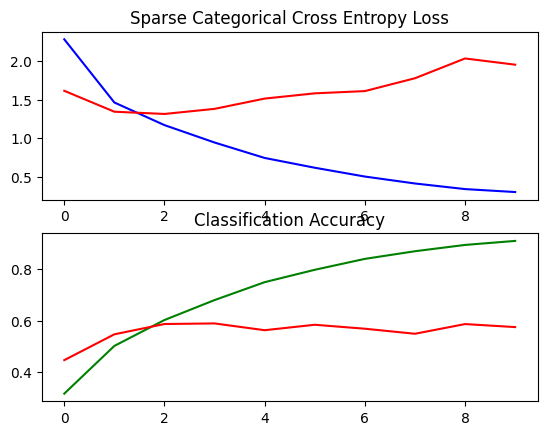

In [17]:
plt.subplot(211)
plt.title('Sparse Categorical Cross Entropy Loss')
plt.plot(model_1_hist.history['loss'], color='blue', label='train')
plt.plot(model_1_hist.history['val_loss'], color='red', label='val')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(model_1_hist.history['accuracy'], color='green', label='train')
plt.plot(model_1_hist.history['val_accuracy'], color='red', label='val')
plt.show()

### Evaluate the model

In [18]:
test_loss, test_acc = model_1.evaluate(test_ds, verbose=1)
print('Test loss => ', test_loss)
print('Test accuracy => ', test_acc)

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5720 - loss: 1.9459
Test loss =>  1.956017017364502
Test accuracy =>  0.5745940804481506


### Test the predictions

In [19]:
import numpy as np
predictions = model_1.predict(test_ds)

print(predictions.shape)
predictions = np.argmax(predictions, axis=1)

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
(5235, 10)


### Print confusion matrix

In [23]:
from sklearn.metrics import confusion_matrix

# Extract ground truth labels from the test dataset
gt = []
for _, labels_batch in test_ds:
    gt.extend(labels_batch.numpy())

gt = np.array(gt)  # Convert gt to a NumPy array

# Calculate and print the confusion matrix
cm = confusion_matrix(gt, predictions)
print(cm)

[[532  77  51  22  66  53  45  46  64  53]
 [ 50 316  21  11  24   2  59  22  28   5]
 [ 27  23 146   3  10   3  32  17  13  11]
 [ 11   4   0 288  28   2   4   2  83   9]
 [ 41  16   7  26 446   9  15  10  22  12]
 [103   7   7  13  31  80   8   3  53  18]
 [ 28  23  23   5  13   3 196  38  15   6]
 [ 51  19  18  10  25   8  58 125  36  10]
 [ 51  11  16  47  27  15   9   8 735  22]
 [ 93  15  13  12  36  21   8  14  38 144]]


Save the model

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
model_1.save("m1_JJ.keras")